In [1]:
#%pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --user

In [2]:
import os
import optuna
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from enum import Enum
import talib
from sklearn.preprocessing import MinMaxScaler

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [4]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers = ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [5]:
def ssl_indicator(df):
    sma_high = talib.SMA(df['high'], 10)
    sma_low = talib.SMA(df['low'], 10)
    hlv = [np.nan]
    for i in range(0, len(df['close'])):
        if df['close'][i] > sma_high[i]:
            hlv.append(1)
        elif df['close'][i] < sma_low[i]:
            hlv.append(-1)
        else:
            hlv.append(hlv[i-1])

    ssl_down = [sma_high[i] if hlv[i] < 0 else sma_low[i] for i in range(len(df.close))]
    ssl_up = [sma_low[i] if hlv[i] < 0 else sma_high[i] for i in range(len(df.close))]

    signals = []
    for i in range(0, len(df.close)):
        if ssl_up[i-1] < ssl_down[i-1] and ssl_up[i] > ssl_down[i]:
            signals.append(1)
        elif ssl_up[i-1] > ssl_down[i-1] and ssl_up[i] < ssl_down[i]:
            signals.append(-1)
        else:
            signals.append(0)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [6]:
def bbands_indicator(df):
    upper_bband_indicator, _, lower_bband_indicator = talib.BBANDS(df["close"], timeperiod=20)

    signals = []
    for i in range(0, len(df.close)):
        if upper_bband_indicator[i] < df['close'][i]:
            signals.append(-1)
        elif lower_bband_indicator[i] > df['close'][i]:
            signals.append(1)
        else:
            signals.append(0)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

[*********************100%***********************]  1 of 1 completed


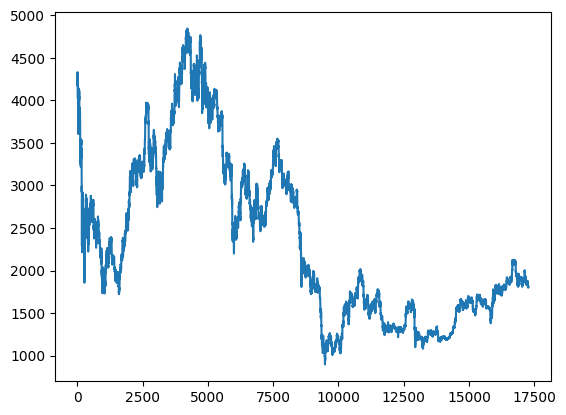

In [7]:
df = getTickerData('eth-usd', '730d', '1h')
df = df.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})
#df['date'] = pd.to_datetime(df['date'])

sma100_indicator = talib.SMA(df['close'], timeperiod=100)
mfi_indicator = talib.MFI(df['high'], df['low'], df['close'], df['volume'])
all_ssl_signals, _, _ = ssl_indicator(df=df)
_, macd_signal_indicator, macd_hist_indicator = talib.MACD(df["close"], fastperiod=12, slowperiod=26, signalperiod=9)
all_bbands_signals, _, _ = bbands_indicator(df=df)

df['sma_100'] = sma100_indicator
df['mfi'] = mfi_indicator
df['ssl_markover'] = all_ssl_signals
df['macd_signal'] = macd_signal_indicator   
df['macd_hist'] = macd_hist_indicator
df['bbands'] = all_bbands_signals

plt.plot(df['close'])

In [8]:
df = df.drop(columns={'volume', 'Adj Close', 'open', 'high', 'low', 'date'})
df = df.dropna()
df

,close,sma_100,mfi,ssl_markover,macd_signal,macd_hist,bbands
99,3856.039062,3963.269634,30.341933,0,-37.664281,11.568948,0
100,3802.619385,3959.404290,34.726953,0,-35.317428,9.387411,0
101,3820.355225,3955.866353,34.726953,0,-33.071977,8.981804,0
102,3848.397705,3951.763875,37.473457,0,-30.485013,10.347854,0
103,3792.366699,3946.379998,35.306268,0,-28.644070,7.363773,0
...,...,...,...,...,...,...,...
17269,1821.011719,1856.870896,40.072955,0,-5.977773,-1.343008,0
17270,1805.682373,1855.861898,28.725843,0,-6.497109,-2.077344,1
17271,1798.202515,1854.757620,21.267965,0,-7.208816,-2.846828,1
17272,1808.461792,1853.791108,27.810672,0,-7.823677,-2.459446,0


In [9]:
scaler = MinMaxScaler()
t_df = scaler.fit_transform(df)
t_df = pd.DataFrame(t_df, columns=df.columns)
t_df

,close,sma_100,mfi,ssl_markover,macd_signal,macd_hist,bbands
0,0.749691,0.788278,0.303419,0.5,0.488195,0.609157,0.5
1,0.736159,0.787230,0.347270,0.5,0.496224,0.592483,0.5
2,0.740651,0.786271,0.347270,0.5,0.503906,0.589383,0.5
3,0.747755,0.785159,0.374735,0.5,0.512756,0.599824,0.5
4,0.733561,0.783700,0.353063,0.5,0.519054,0.577016,0.5
...,...,...,...,...,...,...,...
17170,0.234178,0.217345,0.400730,0.5,0.596597,0.510467,0.5
17171,0.230295,0.217071,0.287258,0.5,0.594821,0.504854,1.0
17172,0.228400,0.216772,0.212680,0.5,0.592386,0.498973,1.0
17173,0.230999,0.216510,0.278107,0.5,0.590282,0.501934,0.5


In [90]:
def calculate_percentage_increase(final_value, starting_value):
    return 100 * ((final_value - starting_value) / starting_value)

In [91]:
class Positions(int, Enum):
    SHORT = 0
    LONG = 1
    HOLD = 2

In [92]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__()        
        self.df = df
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df.shape[1]), dtype=np.float64)
        self.action_space = Discrete(len(Positions))
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.needed_space = self.window_size + self.n_steps
        self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        
        self.positions = []
        self.current_pos = None
        self.held_price = 0
        self.in_a_pos = False
        
        self.trading_positions = 0
        self.profited_trading_positions = 0
        
    def step(self, action):
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        
        reward, p = self.calculate_reward(action)
            
        if action != Positions.HOLD:
            self.current_pos = action
            self.held_price = self.final_value
            self.in_a_pos = True
            
        self.positions.append(action)
        
        self.current_step += 1
        if self.current_step >= self.n_steps:
            done = True
        else:
            done = False
            
        observation = self.get_observation()
        info = {'p': p}
        
        return observation, reward, done, info
        
    def reset(self):
        next_observation = self.get_observation(is_random=True)
        self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        self.done = False
        self.current_step = 0
        self.positions.clear()
        next_observation = self.get_observation(is_random=True)
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.held_price = 0
        self.in_a_pos = False
        self.loss_positions = 0
        self.trading_positions = 0
        self.profited_trading_positions = 0
        return next_observation
    
    def get_observation(self, is_random=False):
        if is_random:
            self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        return self.df.iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].values
    
    def final_render(self):
        final_observation = self.df.iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+len(self.positions)]['close']
        
        winrate = round(self.profited_trading_positions / self.trading_positions, 5)
            
        buy_signal = [True if self.positions[n]==Positions.LONG else False for n in range(0, len(self.positions))]
        sell_signal = [True if self.positions[n]==Positions.SHORT else False for n in range(0, len(self.positions))]
        hold_signal = [True if self.positions[n]==Positions.HOLD else False for n in range(0, len(self.positions))]
        buy_signal.append(False)
        sell_signal.append(False)
        hold_signal.append(False)
        
        plt.figure(figsize=(20,7))
        plt.plot(final_observation, color='c', lw=2.)
        plt.plot(final_observation, '^', markersize=10, color='g', label = 'Buying signal', markevery = buy_signal)
        plt.plot(final_observation, 'v', markersize=10, color='r', label = 'Selling signal', markevery = sell_signal)
        plt.plot(final_observation, 'o', markersize=6, color='b', label = 'Holding signal', markevery = hold_signal)
        plt.xticks([])
        plt.title("Final result of the last trading session")
        plt.ylabel('Close price')
        plt.legend()
        plt.show()
        
        return winrate
    
    def calculate_reward(self, action):
        """Calculate the reward function for the model here
        Example:\n
        reward = 1\n
        return reward"""
        raise NotImplementedError    

In [93]:
class Trading(TradingEnv):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__(df, n_steps, window_size)
        
    def calculate_reward(self, action):
        reward = 0
        percentage = 0.
        
        if self.in_a_pos:
            ratio = self.final_value / self.held_price
            
            if self.current_pos == Positions.SHORT: 
                reward = -np.log(ratio)
                    
            if self.current_pos == Positions.LONG:
                reward = np.log(ratio)
                
            if action != Positions.HOLD:
                self.trading_positions+=1
                if reward > 0:
                    self.profited_trading_positions+=1
        
        if self.in_a_pos and action != Positions.HOLD:
            percentage = calculate_percentage_increase(self.final_value, self.held_price)
            if self.current_pos == Positions.SHORT:
                percentage = -percentage
            
        return reward, percentage

In [94]:
env = Trading(t_df, window_size=90, n_steps=100)
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


PERCENTAGE 0.0
PERCENTAGE -0.41507677555081746
PERCENTAGE 1.248670758490685
PERCENTAGE -0.7880564537843187
PERCENTAGE 0.6573669638808126
PERCENTAGE 0.0
PERCENTAGE 0.0
PERCENTAGE -0.832976555197439
PERCENTAGE -0.3940081112903929
PERCENTAGE 0.0
PERCENTAGE -0.17134405360986338
PERCENTAGE 0.0
PERCENTAGE 0.0
PERCENTAGE -2.3577121204614837
PERCENTAGE 0.7127241845577169
PERCENTAGE 0.7163655867147872
PERCENTAGE 1.1080454629900451
PERCENTAGE 0.0
PERCENTAGE 0.0
PERCENTAGE -0.36531128376369737
PERCENTAGE -1.0524372821225196
PERCENTAGE 0.8218378437176334
PERCENTAGE -0.5912010152939513
PERCENTAGE -0.5866752512365824
PERCENTAGE 0.6214173484520816
PERCENTAGE 0.0
PERCENTAGE 0.9246129834496221
PERCENTAGE -0.26398713579665184
PERCENTAGE -0.7072758972000619
PERCENTAGE 0.0
PERCENTAGE 0.0
PERCENTAGE -1.7339028273102592
PERCENTAGE -0.01775549097970658
PERCENTAGE 0.0
PERCENTAGE 0.007373116947534442
PERCENTAGE -0.18907304886349963
PERCENTAGE 0.34890285233174195
PERCENTAGE 0.5827316228467638
PERCENTAGE -0.2062

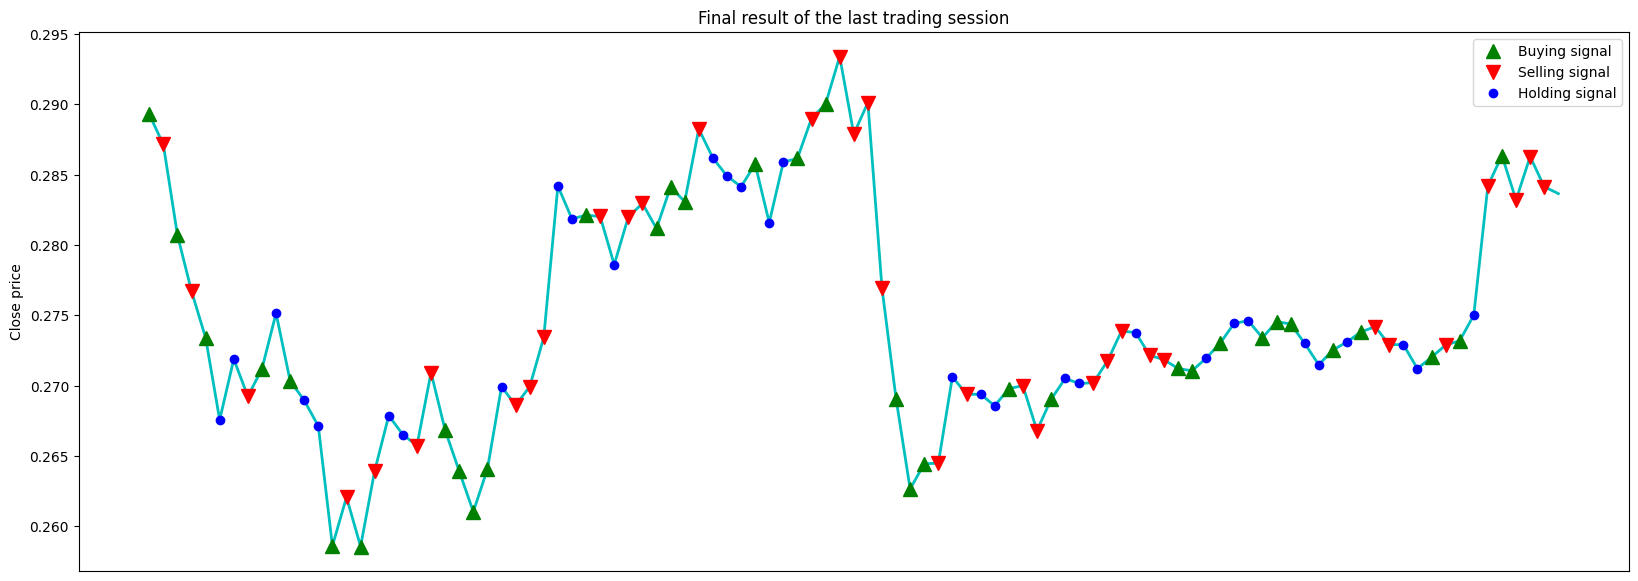

episode - 1 || score - 0.011949778970243529
0.54412


In [95]:
episodes = 1
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    ss = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
        #print('REWARD', reward)
        print('PERCENTAGE', info['p'])
    winrate = env.final_render()
    print(f'episode - {n} || score - {score}')
    print(winrate)

In [15]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'
OPT_DIR = './opt/'

In [16]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [223]:
def optimize_ppo(trial):
    return {
        'n_steps': trial.suggest_int('n_steps', 64, 8192),
        'gamma': trial.suggest_loguniform('gamma', 0.8, 0.9999),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 1e-4),
        'clip_range': trial.suggest_uniform('clip_range', 0.1, 0.4),
        'gae_lambda': trial.suggest_uniform('gae_lambda', 0.8, 0.99),
        'ent_coef': trial.suggest_uniform('ent_coef', 0.001, 0.01)
    }

In [224]:
def optimize_agent(trial):
    try:
        model_params=optimize_ppo(trial)
        env = Trading(df, window_size=90, n_steps=100)
        
        model = RecurrentPPO('MlpLstmPolicy', env, verbose=0, tensorboard_log=LOG_DIR, **model_params)
        model.learn(100000)
        
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        env.close()
        
        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        
        return mean_reward
    except Exception as e:
        return -1000

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent, n_trials=35, n_jobs=1)

In [ ]:
study.best_params

{'n_steps': 7917,
 'gamma': 0.8148319613766952,
 'learning_rate': 1.1494222672968137e-05,
 'clip_range': 0.11454224768088915,
 'gae_lambda': 0.9747187305774679,
 'ent_coef': 0.007806731954039324}

In [102]:
model = RecurrentPPO('MlpLstmPolicy', env, verbose=0, tensorboard_log=LOG_DIR, 
                     n_steps=7917,
                     gamma=0.8148319613766952, 
                     learning_rate=1.1494222672968137e-05,
                     clip_range=0.11454224768088915,
                     gae_lambda=0.9747187305774679,
                     ent_coef=0.007806731954039324)

In [96]:
loaded_model = RecurrentPPO.load('./saved_models/best_model_5900000_rrs', env=env)

In [ ]:
opt_model = RecurrentPPO.load('./saved_models/opt_model_training_1', env=env)

In [22]:
loaded_model.learn(total_timesteps=5000000, callback=callback)

KeyboardInterrupt: 

In [127]:
evaluate_policy(model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(0.060245659873271504, 0.06888187467287289)

In [18]:
evaluate_policy(loaded_model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(1.8287345030230426, 2.3768329558035974)

In [80]:
evaluate_policy(opt_model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(-0.006837816031838884, 0.07551070536538326)

In [198]:
def test_portfolio(model, starting_money, amount_to_use):
    obs = env.reset()
    done = False
    score = 0
    portfolio = starting_money
    portfolio_accumulation_results = []
    percentage_increase = 0
    total_profit_percentage = 0
    total_profit = 0
    
    while not done:
        action, lstm_cells = model.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        percentage_increase = info['p']
        
        total_profit += ((portfolio * amount_to_use) * percentage_increase)
        portfolio_change = portfolio + ((portfolio * amount_to_use) * percentage_increase)
        portfolio = portfolio_change
        
        portfolio_accumulation_results.append(portfolio_change)
        plt.plot(portfolio_accumulation_results)
        
    env.final_render()
    total_profit_percentage += calculate_percentage_increase(portfolio, starting_money)
    print(f'score - {score}')
    print(f'Profit percentage - {total_profit_percentage}')
    print(f'Profit - {total_profit}')

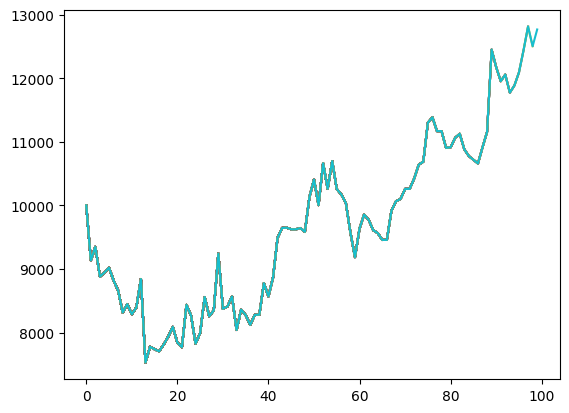

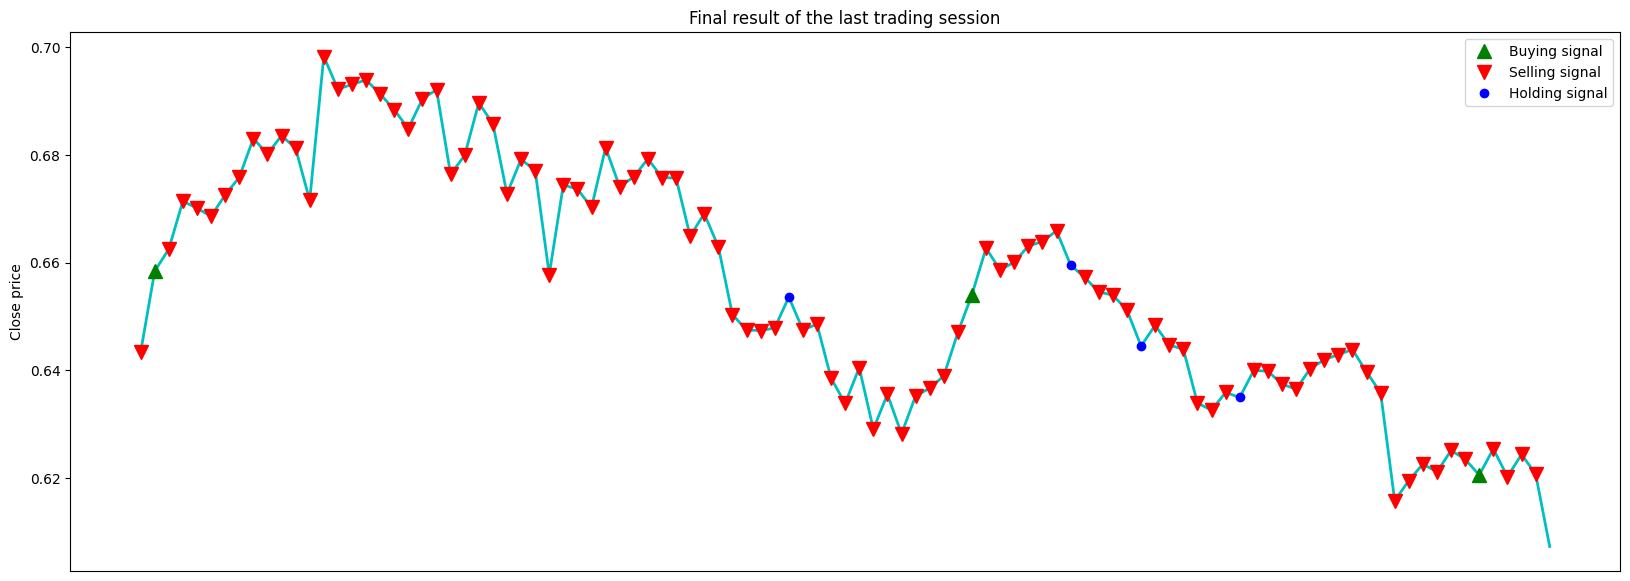

score - 0.07566729811374792
Profit percentage - 27.679315755144163
Profit - 2767.931575514419


In [200]:
test_portfolio(loaded_model, starting_money=10000, amount_to_use=0.05)